# Computational Finance

## Lab Assignment 2

This notebook makes use of a python 3 environment by default.

Authors:
- Kevin de Vries
- Jedda Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 11398221
- 11391952

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Keeps results reproducible
np.random.seed(23456)

# Part 1: Basic Option Valuation

In [2]:
def European(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of European option simulations
    """
    
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    batch = np.maximum(0, S_T - K) if call else np.maximum(0,K - S_T)
    return batch

def MC_option_values(S0,K,r,sigma,T,N,M=100000,N_sim=30,
                     call=False,payoff=European,path=False,
                     antithetic=True,control_variable=None,control_analytic=None,stats=True):
    """
    Calculates a number of option values using a Monte Carlo method. 
    The option to use antithetic variables is on by default.
    
    The value is determined as the mean of a 
    batch of payoffs discounted with the interest rate.
    
    Returns the mean of the calculated options and its standard error
    
    call:
        Determines if call or put option
    payoff:
        Function which calculates the payoff of the option style
    path:
        Determines if the full path of the stock price has to be simulated.
    antithetic:
        Determines if to apply variance reduction using antithetic variables
    control_variable:
        Function with option payoff to be used as control variable
    control_analytic:
        Function with the black-scholes price of the control variable
    stats:
        Determines if the mean and standard error of the option values are returned
    """
    
    if path:
        Z = np.random.normal(0,1,(M,N_sim,N))
    else:
        Z = np.random.normal(0,1,(M,N_sim))
    
    batch = payoff(S0,K,r,sigma,T,N,Z,call,path)
    values = np.exp(-r*T) * np.mean(batch,axis=0)
    
    if antithetic:
        batch = payoff(S0,K,r,sigma,T,N,-Z,call,path)
        values_min = np.exp(-r*T) * np.mean(batch,axis=0)
        values = (values + values_min) / 2
    
    if control_variable:
        batch = control_variable(S0,K,r,sigma,T,N,Z,call,path)
        control = np.exp(-r*T) * np.mean(batch,axis=0)
    
        if antithetic:
            batch = control_variable(S0,K,r,sigma,T,N,-Z,call,path)
            control_min = np.exp(-r*T) * np.mean(batch,axis=0)
            control = (control + control_min) / 2
    
        # Calculate analytic control variate option valuation
        analytic, _ = control_analytic(S0,K,r,sigma,T,N)

        # Minimize scale variable beta
        control_centered = control-np.mean(control)
        beta = np.sum( (values-np.mean(values)) * control_centered ) / np.sum(control_centered**2)
        
        values = values - beta*(control-analytic)
    
    if stats:
        mean,std = data_stats(values)
        return values,mean,std
    else:
        return values
    
def data_stats(data):
    mean = np.mean(data)
    var = np.sum((data-mean)**2) / (data.size - 1)
    std_err = np.sqrt(var/data.size)
    return mean,std_err

In [3]:
# Calculate European option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 1
M, N_sim = 10000,30

# Option values and stats using mean payoffs
values,mean,std = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,antithetic=False)

print("Mean: %f" % mean)
print("Standard error: %f" % std)

# Option values and stats using mean payoffs with antithetic variables
values,mean,std = MC_option_values(S0,K,r,sigma,T,N,M,N_sim)

print("Mean: %f" % mean)
print("Standard error: %f" % std)

Mean: 4.789625
Standard error: 0.013258
Mean: 4.773392
Standard error: 0.008631


# Part 2: Estimation of Sensitivities in MC

In [4]:
def digital(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of digital option simulations
    which pay 1 euro when the option expires with the
    stock price beyond the strike price.
    """
    
    S_T = S0 * np.exp((r - sigma**2 / 2)*T + sigma*Z*np.sqrt(T))
    batch = np.zeros(Z.shape)
    if call:
        batch[S_T > K] = 1
    else:
        batch[S_T < K] = 1
    
    return batch

In [5]:
# Calculate European option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, M = 1,100000
call = False

N_sim = 30
eps = 0.001

# Different seeds
unbumped = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,call)
bumped = MC_option_values(S0+eps,K,r,sigma,T,N,M,N_sim,call)

# Calculate delta from estimate means
deltas = (bumped[0]-unbumped[0]) / eps

mu_delta,std_delta = data_stats(deltas)

print("Different seeds:\n")
print("Mean: %f" % unbumped[1])
print("Standard error: %f\n" % unbumped[2])
print("Hedge parameter estimate: %f" % mu_delta)
print("Hedge parameter standard error: %f\n" % std_delta)

# Same seed
seed = 12

np.random.seed(seed)
unbumped = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,call)
np.random.seed(seed)
bumped = MC_option_values(S0+eps,K,r,sigma,T,N,M,N_sim,call)

# Calculate delta from estimate means
deltas = (bumped[0]-unbumped[0]) / eps

mu_delta,std_delta = data_stats(deltas)

print("Same seed:\n")
print("Mean: %f" % unbumped[1])
print("Standard error: %f\n" % unbumped[2])
print("Hedge parameter estimate: %f" % mu_delta)
print("Hedge parameter standard error: %f" % std_delta)

Different seeds:

Mean: 4.777819
Standard error: 0.002442

Hedge parameter estimate: 2.441588
Hedge parameter standard error: 3.556196

Same seed:

Mean: 4.780265
Standard error: 0.002532

Hedge parameter estimate: -0.326319
Hedge parameter standard error: 0.000098


# Part 3: Variance Reduction

In [6]:
def geometric_Asian(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of geometric Asian option simulations
    """
    if path:
        dt = T / N
    
        mu = (r-0.5*sigma**2)*dt
        std = sigma*np.sqrt(dt)
    
        M, N_sim, _ = Z.shape
        batch = np.zeros((M,N_sim))
    
        S = np.zeros(N+1)
        S[0] = S0
        for m in range(M):
            for n in range(N_sim):
                for i in range(1,N+1):
                    S[i] = S[i-1]*np.exp(mu + std*Z[m,n,i-1])
                S_G = np.prod(S[1:]**(1/N))
                batch[m,n] = max(0,S_G - K) if call else max(0,K - S_G)
    
    else:
        mu = (r-0.5*sigma**2) * (N+1) * T / (2*N)
        std = sigma * np.sqrt((N+1) * (2*N+1) * T / (6*N**2))
        
        S_G = S0*np.exp(mu + std*Z)
        batch = np.maximum(0, S_G - K) if call else np.maximum(0,K - S_G)
    
    return batch

def arithmetic_Asian(S0,K,r,sigma,T,N,Z,call,path):
    """
    Calculates the payoff of arithmetic Asian option simulations
    """
    
    dt = T / N
    
    mu = (r-0.5*sigma**2)*dt
    std = sigma*np.sqrt(dt)
    
    M, N_sim, _ = Z.shape
    batch = np.zeros((M,N_sim))
    
    S = np.zeros(N+1)
    S[0] = S0
    for m in range(M):
        for n in range(N_sim):
            for i in range(1,N+1):
                S[i] = S[i-1]*np.exp(mu + std*Z[m,n,i-1])
            S_A = np.mean(S[1:])
            batch[m,n] = max(0,S_A - K) if call else max(0,K - S_A)
    
    return batch

def black_scholes_geometric_asian(S0,K,r,sigma,T,N,call=False):
    mu = (r-0.5*sigma**2) * (N+1) * T / (2*N)
    std = sigma * np.sqrt((N+1) * (2*N+1) * T / (6*N**2))
    
    d2 = (np.log(S0/K) + mu) / std
    d1 = d2 + std
    
    discount = np.exp(mu+0.5*std**2-r*T)
    if call:
        price = S0*discount*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        delta = discount*norm.cdf(d1)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S0*discount*norm.cdf(-d1)
        delta = -discount*norm.cdf(-d1)
    
    return price,delta

In [7]:
# Calculate Asian option value using Batch Monte Carlo
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
M, N_sim = 1000000, 30

eps = 0.001

seed = 12

for call in [True,False]:
    np.random.seed(seed)
    unbumped = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,call,payoff=geometric_Asian)
    np.random.seed(seed)
    bumped = MC_option_values(S0+eps,K,r,sigma,T,N,M,N_sim,call,payoff=geometric_Asian)

    # Calculate delta from estimate means
    deltas = (bumped[0]-unbumped[0]) / eps

    mu_delta,std_delta = data_stats(deltas)

    print("Asian geometric %s\n" % ("call" if call else "put"))
    
    print("Mean: %f" % unbumped[1])
    print("Standard error: %f\n" % unbumped[2])
    print("Hedge parameter estimate: %f" % mu_delta)
    print("Hedge parameter standard error: %f\n" % std_delta)

    price,delta = black_scholes_geometric_asian(S0,K,r,sigma,T,N,call)

    print("Black-Scholes price: %f" % price)
    print("Black-Scholes delta: %f\n" % delta)

Asian geometric call

Mean: 6.752416
Standard error: 0.000695

Hedge parameter estimate: 0.628818
Hedge parameter standard error: 0.000027

Black-Scholes price: 6.752147
Black-Scholes delta: 0.628809

Asian geometric put

Mean: 3.021051
Standard error: 0.000518

Hedge parameter estimate: -0.340842
Hedge parameter standard error: 0.000028

Black-Scholes price: 3.020874
Black-Scholes delta: -0.340850



In [8]:
# Analysis convergence geometric Asian option price

S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
N_sim = 30

analytic, _ = black_scholes_geometric_asian(S0,K,r,sigma,T,N,call=False)

M_vals = list(range(100,1000,100)) + list(range(1000,100001,1000))
stats = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,payoff=geometric_Asian)
    
    stats[i,:] = mean, std

Black-Scholes price: 3.020874
MC price estimate: 3.020630
MC price standard error: 0.002220


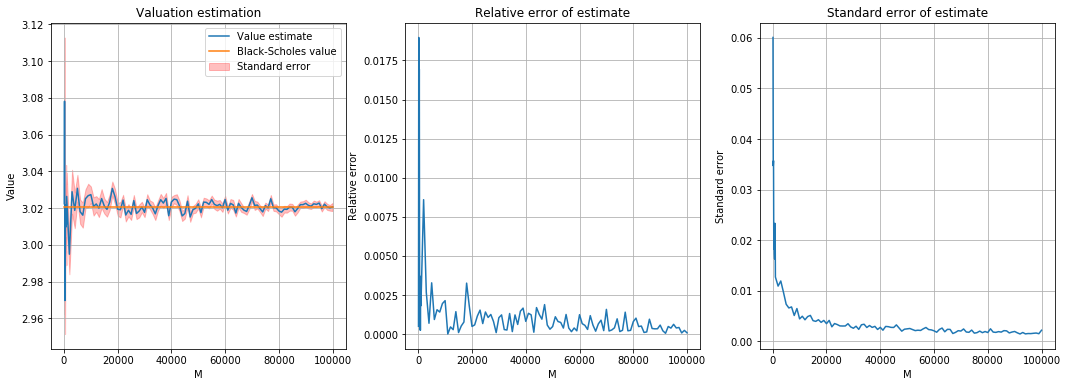

In [9]:
# Plot analysis results

print("Black-Scholes price: %f" % analytic)
print("MC price estimate: %f" % stats[-1,0])
print("MC price standard error: %f" % stats[-1,1])

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title("Valuation estimation")
plt.xlabel("M")
plt.ylabel("Value")
plt.grid()
plt.plot(M_vals,stats[:,0],label="Value estimate")
plt.fill_between(M_vals,stats[:,0]+stats[:,1],stats[:,0]-stats[:,1],
                 color='r',alpha=0.25,label="Standard error")

plt.plot([0,M_vals[-1]],[analytic,analytic],label="Black-Scholes value")
plt.legend()
plt.subplot(1,3,2)
plt.title("Relative error of estimate")
plt.xlabel("M")
plt.ylabel("Relative error")
plt.grid()
plt.plot(M_vals,abs((stats[:,0]-analytic) / analytic))
plt.subplot(1,3,3)
plt.title("Standard error of estimate")
plt.xlabel("M")
plt.ylabel("Standard error")
plt.grid()
plt.plot(M_vals,stats[:,1])
plt.show()

In [10]:
# Control variate test
S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
M, N_sim = 10000, 30

seed = 123
np.random.seed(seed)

# Arithmetic Asian option
arithmetic = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,
                              payoff=arithmetic_Asian,path=True,antithetic=True)

print("Arithmetic normal:\n")
print("Mean: %f" % arithmetic[1])
print("Standard error: %f\n" % arithmetic[2])

# Arithmetic Asian option with control variable
control = MC_option_values(S0,K,r,sigma,T,N,M,N_sim,
                           payoff=arithmetic_Asian,path=True,antithetic=True,
                           control_variable=geometric_Asian,
                           control_analytic=black_scholes_geometric_asian)

"""
cov = np.sum( (arithmetic[0]-arithmetic[1]) * geo_centered ) / (N_sim-1)
varX = np.sum((arithmetic[0]-arithmetic[1])**2) / (N_sim-1)
varY = np.sum(geo_centered**2) / (N_sim-1)
corr = cov / np.sqrt(varX*varY)

print("Correlation: %f\n" % corr)
"""

print("Arithmetic with control variable:\n")
print("Mean: %f" % control[1])
print("Standard error: %f\n" % control[2])

Arithmetic normal:

Mean: 2.922167
Standard error: 0.004621

Arithmetic with control variable:

Mean: 2.917534
Standard error: 0.000121



In [11]:
# Analysis convergence arithmetic Asian option price

S0, K = 100, 99
r, sigma = 0.06, 0.2
T, N = 1, 12
N_sim = 30

M_vals = list(range(10,100,10)) + list(range(100,1000,100)) + list(range(1000,10001,1000))

np.random.seed(12345)

In [12]:
# Normal arithmetic asian option
arithmetic = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,path=True,antithetic=False,payoff=arithmetic_Asian)
    
    arithmetic[i,:] = mean, std

print("Done")

Done


In [13]:
# Arithmetic asian option with control variates
control = np.zeros((len(M_vals), 2))
for i in range(len(M_vals)):
    _,mean,std = MC_option_values(S0,K,r,sigma,T,N,M_vals[i],N_sim,
                                  call=False,payoff=arithmetic_Asian,path=True,antithetic=False,
                                  control_variable=geometric_Asian,
                                  control_analytic=black_scholes_geometric_asian)
    
    control[i,:] = mean, std

print("Done")

Done


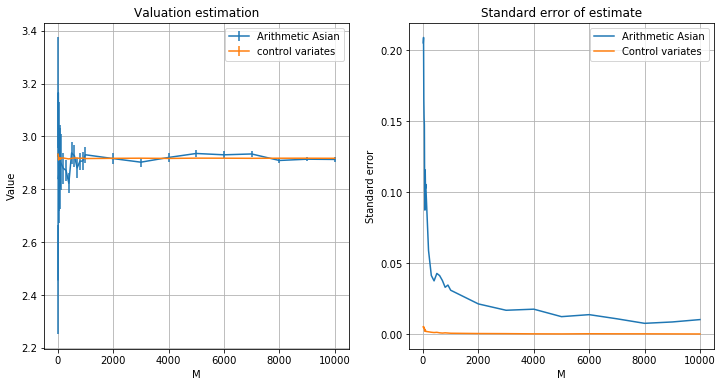

In [15]:
# Plot analysis results

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Valuation estimation")
plt.xlabel("M")
plt.ylabel("Value")
plt.grid()

plt.errorbar(M_vals,arithmetic[:,0],arithmetic[:,1],label="Arithmetic Asian")
"""
plt.plot(M_vals,arithmetic[:,0],'o-',label="Arithmetic Asian")
plt.fill_between(M_vals,arithmetic[:,0]+arithmetic[:,1],arithmetic[:,0]-arithmetic[:,1],
                 color='r',alpha=0.25,label="Arithmetic Asian standard error")
"""

plt.errorbar(M_vals,control[:,0],control[:,1],label="control variates")
"""
plt.plot(M_vals,control[:,0],'o-',label="control variates")
plt.fill_between(M_vals,control[:,0]+control[:,1],control[:,0]-control[:,1],
                 color='b',alpha=0.25,label="Control variates standard error")
"""

plt.legend()
plt.subplot(1,2,2)
plt.title("Standard error of estimate")
plt.xlabel("M")
plt.ylabel("Standard error")
plt.grid()
plt.plot(M_vals,arithmetic[:,1],label="Arithmetic Asian")
plt.plot(M_vals,control[:,1],label="Control variates")
plt.legend()

plt.show()